# kaggle competitions -c multi-class-classification-for-predicting-cirrhosi

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import mstats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
import warnings
warnings.filterwarnings("ignore")

In [3]:
test = pd.read_csv('test.csv')
print(test.shape)

(10000, 19)


In [4]:
train = pd.read_csv('train.csv')
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1086.0,NaN,18628.0,F,NaN,NaN,NaN,N,0.9,NaN,3.01,NaN,NaN,NaN,NaN,244.0,10.0,2.0,C
1,1,3231.0,NaN,18263.0,F,NaN,NaN,NaN,N,0.9,NaN,4.01,NaN,NaN,NaN,NaN,244.0,10.9,2.0,C
2,2,1072.0,NaN,14245.0,F,NaN,NaN,NaN,N,1.0,NaN,3.50,NaN,NaN,NaN,NaN,209.0,10.8,2.0,C
3,3,3611.0,Placebo,20604.0,F,N,Y,Y,N,0.5,248.0,3.43,54.0,1260.0,72.85,106.0,430.0,10.6,2.0,D
4,4,2657.0,NaN,17897.0,F,NaN,NaN,NaN,N,0.9,NaN,3.93,NaN,NaN,NaN,NaN,209.0,10.0,2.0,C


In [5]:
train['Status'].value_counts()

Status
C     10209
D      4446
CL      345
Name: count, dtype: int64

- here i can clerly see c is dominating . and our data is imbalanced

# stat

In [6]:
train.describe().loc[['mean','50%'],:]

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
mean,7499.5,1973.4756,19340.555467,1.865493,328.211217,3.530185,75.039084,1659.493211,106.320257,110.97573,253.686776,10.619235,3.0182
50%,7499.5,1783.0000,19577.000000,0.900000,280.000000,3.600000,52.000000,1070.000000,97.650000,99.00000,249.000000,10.600000,3.0000


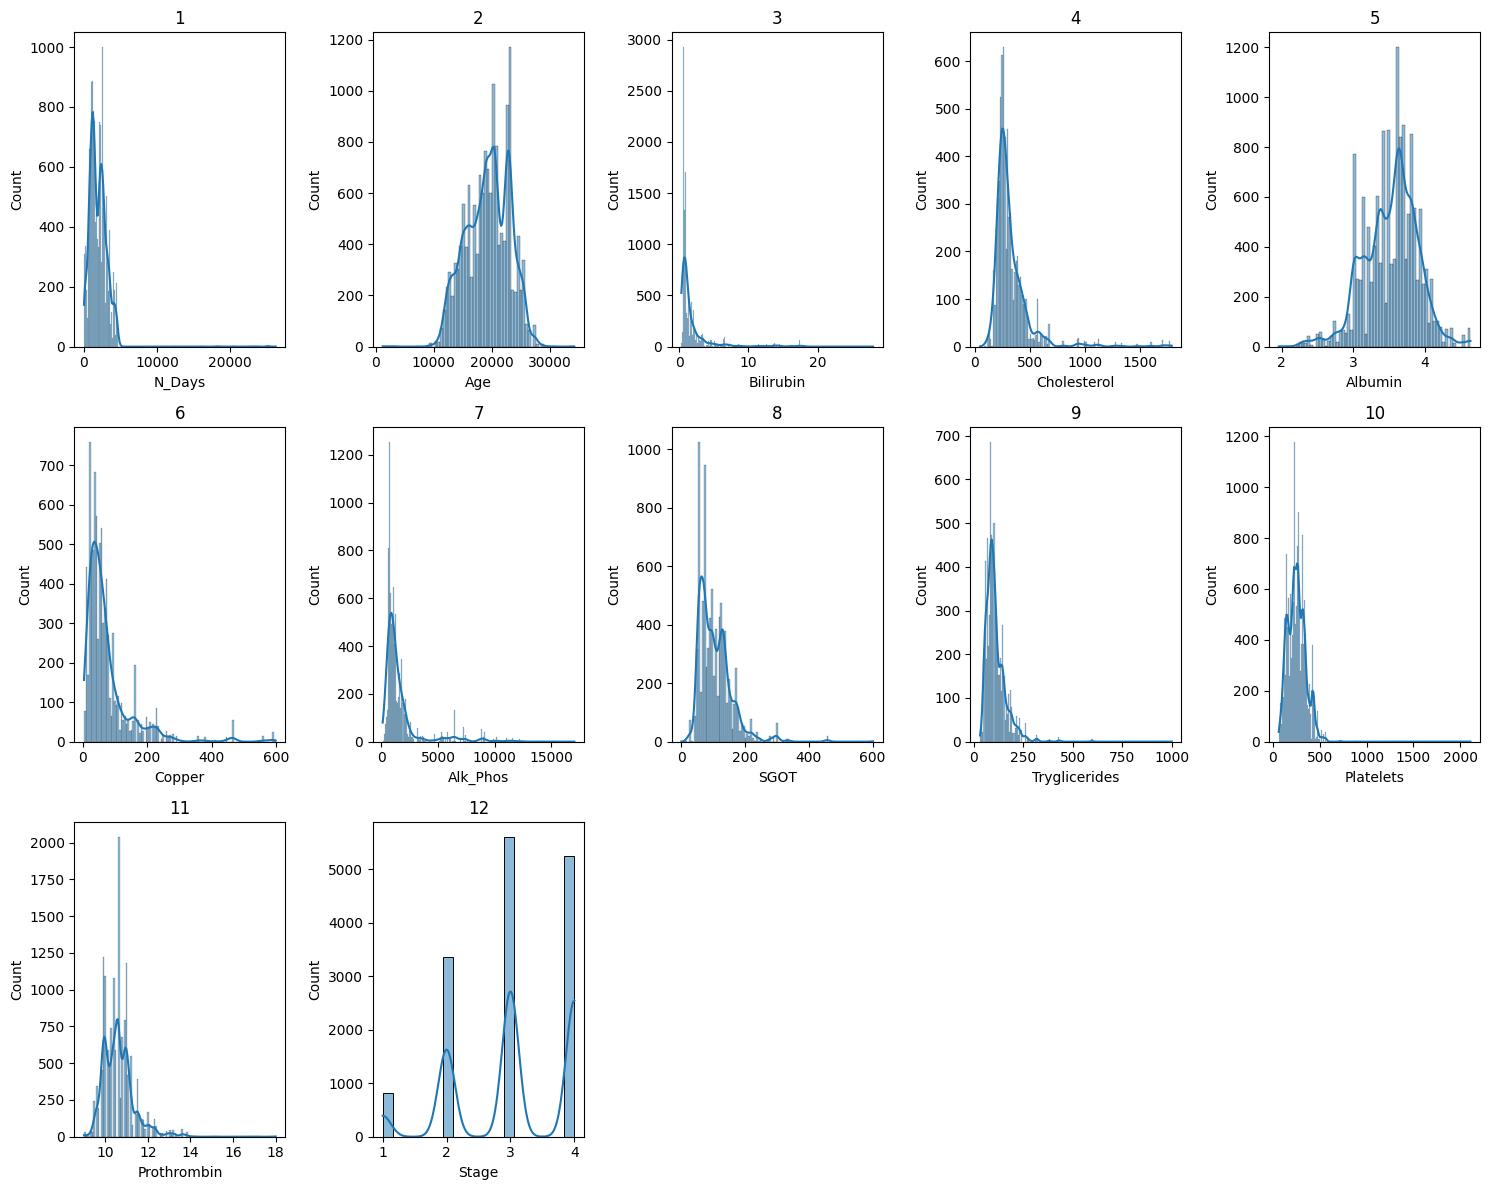

In [7]:
num_col = train.select_dtypes('number').drop(columns='id')
plt.figure(figsize=(15,12))
for i,j in enumerate(num_col.columns,1):
    plt.subplot(3,5,i)
    sns.histplot(train[j],kde=True)
    plt.title(i)
plt.tight_layout()

-  age and albumin as normally distrubuted otherwise all the other columns are rightly skewed.

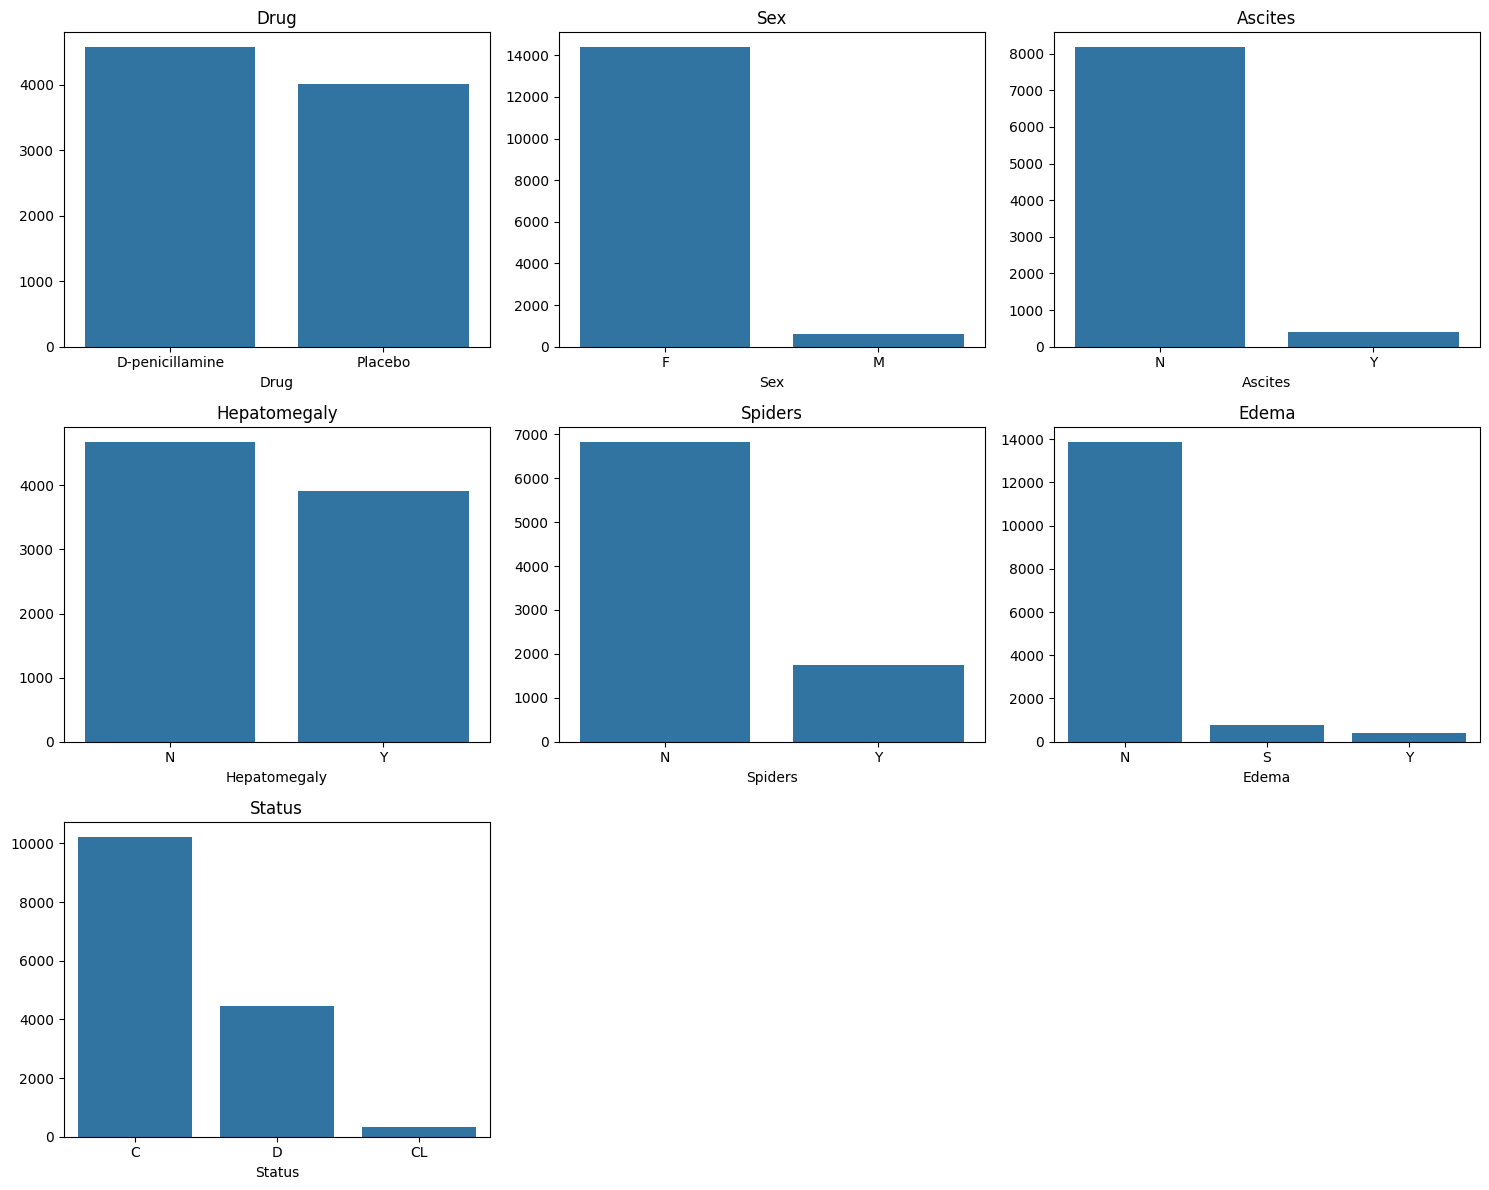

In [8]:
cat_col = train.select_dtypes('object')
plt.figure(figsize=(15,12))
for i,j in enumerate(cat_col.columns,1):
    plt.subplot(3,3,i)
    sns.barplot(x=train[j].value_counts().index,y=train[j].value_counts().values)
    plt.title(j)
plt.tight_layout()

- in sex column there is highly imbalanced data.
- ascities and spider also have imbalanced but there are missing value that may be impacting balancing.
- edema column also have imbalanced data.

# eda

In [9]:
train.isna().sum()/len(train) * 100

id                0.000000
N_Days            0.000000
Drug             42.793333
Age               0.000000
Sex               0.000000
Ascites          42.766667
Hepatomegaly     42.793333
Spiders          42.840000
Edema             0.000000
Bilirubin         0.000000
Cholesterol      55.306667
Albumin           0.000000
Copper           43.540000
Alk_Phos         42.846667
SGOT             42.866667
Tryglicerides    55.680000
Platelets         3.860000
Prothrombin       0.146667
Stage             0.000000
Status            0.000000
dtype: float64

- here i can see there are two columns with more than 50 percent data missing..('Cholesterol','Tryglicerides'). so it is better we can drop those columns.

# outliers

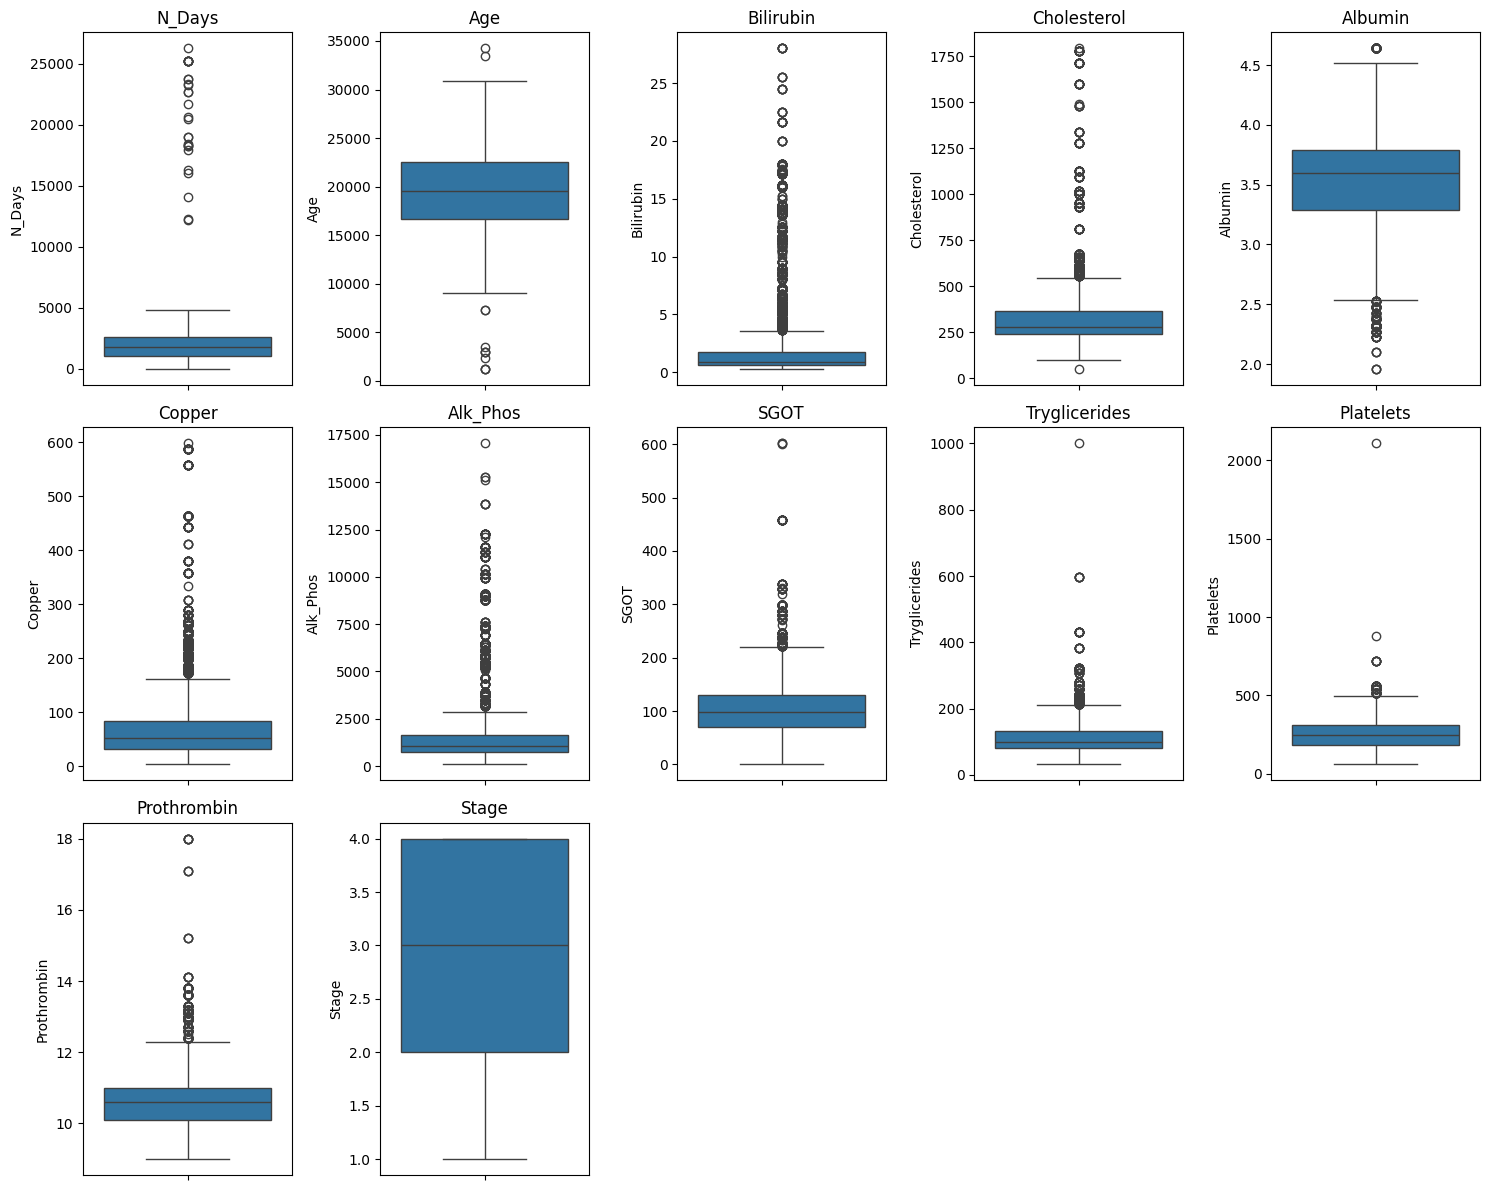

In [10]:
plt.figure(figsize=(15,12))
for i,j in enumerate(num_col.columns,1):
    plt.subplot(3,5,i)
    sns.boxplot(train[j])
    plt.title(j)
plt.tight_layout()

-  almost every column has outliers

# relationship between cat columns with output

In [12]:
for col in cat_col:
    crosstab = pd.crosstab(train[col],train['Status'])
    chi2,p,dof,ex = chi2_contingency(crosstab)
    print('p value is',col,'-',p)


p value is Drug - 0.05187244568219594
p value is Sex - 3.3564521343572775e-43
p value is Ascites - 1.4063671375098284e-204
p value is Hepatomegaly - 0.0
p value is Spiders - 1.0193449938513057e-251
p value is Edema - 1.4289898742419438e-293
p value is Status - 0.0


- edema is a important feature bcoz p-value is very less. we can see other features p-value is also les then 0.05 but for now i am not considering other columns
bcoz imbalanced and missing values

# missing values filling num col

In [13]:
num_col.isna().sum()

N_Days              0
Age                 0
Bilirubin           0
Cholesterol      8296
Albumin             0
Copper           6531
Alk_Phos         6427
SGOT             6430
Tryglicerides    8352
Platelets         579
Prothrombin        22
Stage               0
dtype: int64

In [14]:
train = train.drop(columns=['Cholesterol', 'Tryglicerides'])

In [15]:
num_col.skew()

N_Days           5.972603
Age             -0.215388
Bilirubin        4.158029
Cholesterol      4.299325
Albumin         -0.317266
Copper           3.155145
Alk_Phos         3.250827
SGOT             2.045203
Tryglicerides    2.897871
Platelets        0.973768
Prothrombin      1.613499
Stage           -0.497697
dtype: float64

In [16]:
imputer = IterativeImputer(max_iter=10,random_state=0)
for col in train.select_dtypes('number'):
    train[[col]] = imputer.fit_transform(train[[col]])
print(train.isnull().sum())

id                 0
N_Days             0
Drug            6419
Age                0
Sex                0
Ascites         6415
Hepatomegaly    6419
Spiders         6426
Edema              0
Bilirubin          0
Albumin            0
Copper             0
Alk_Phos           0
SGOT               0
Platelets          0
Prothrombin        0
Stage              0
Status             0
dtype: int64


# missing values filling cat col

In [17]:
cat_col.isna().sum()

Drug            6419
Sex                0
Ascites         6415
Hepatomegaly    6419
Spiders         6426
Edema              0
Status             0
dtype: int64

In [18]:
for col in ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']:
    train[col].fillna('Missing',inplace=True)

In [19]:
train.isna().sum()

id              0
N_Days          0
Drug            0
Age             0
Sex             0
Ascites         0
Hepatomegaly    0
Spiders         0
Edema           0
Bilirubin       0
Albumin         0
Copper          0
Alk_Phos        0
SGOT            0
Platelets       0
Prothrombin     0
Stage           0
Status          0
dtype: int64

# after filling viz

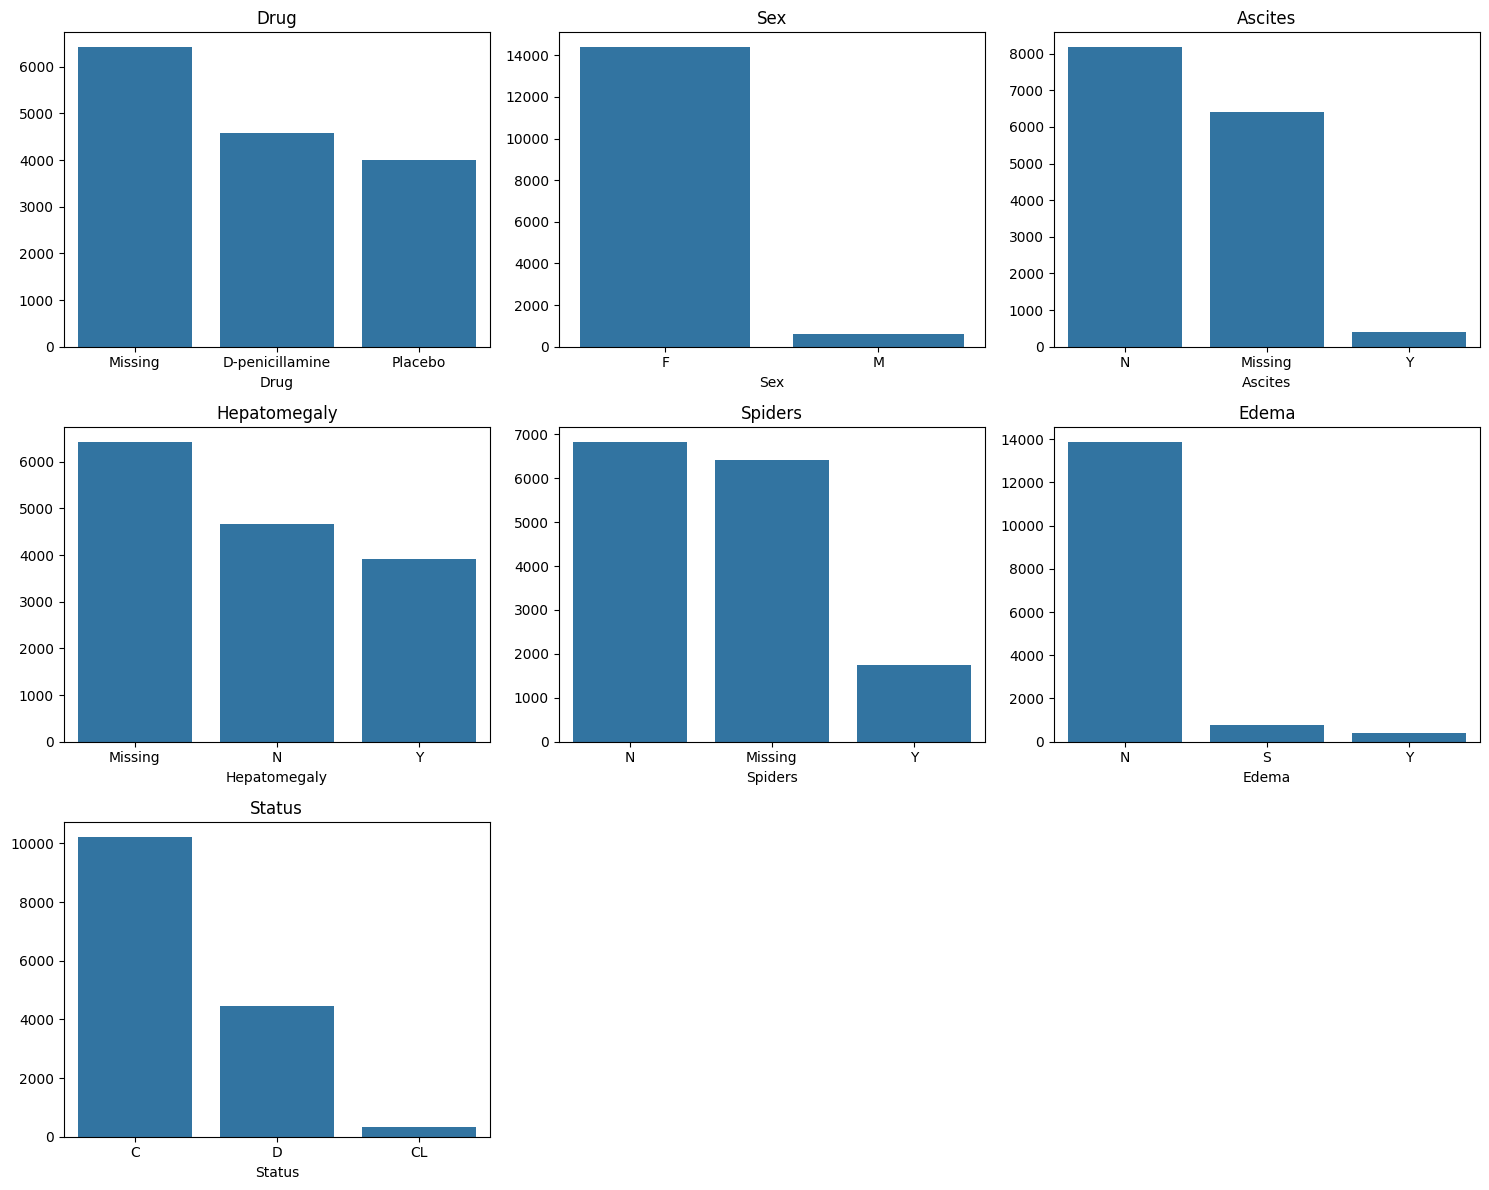

In [20]:
cat_col = train.select_dtypes('object')
plt.figure(figsize=(15,12))
for i,j in enumerate(cat_col.columns,1):
    plt.subplot(3,3,i)
    sns.barplot(x=train[j].value_counts().index,y=train[j].value_counts().values)
    plt.title(j)
plt.tight_layout()

# outliers treatment

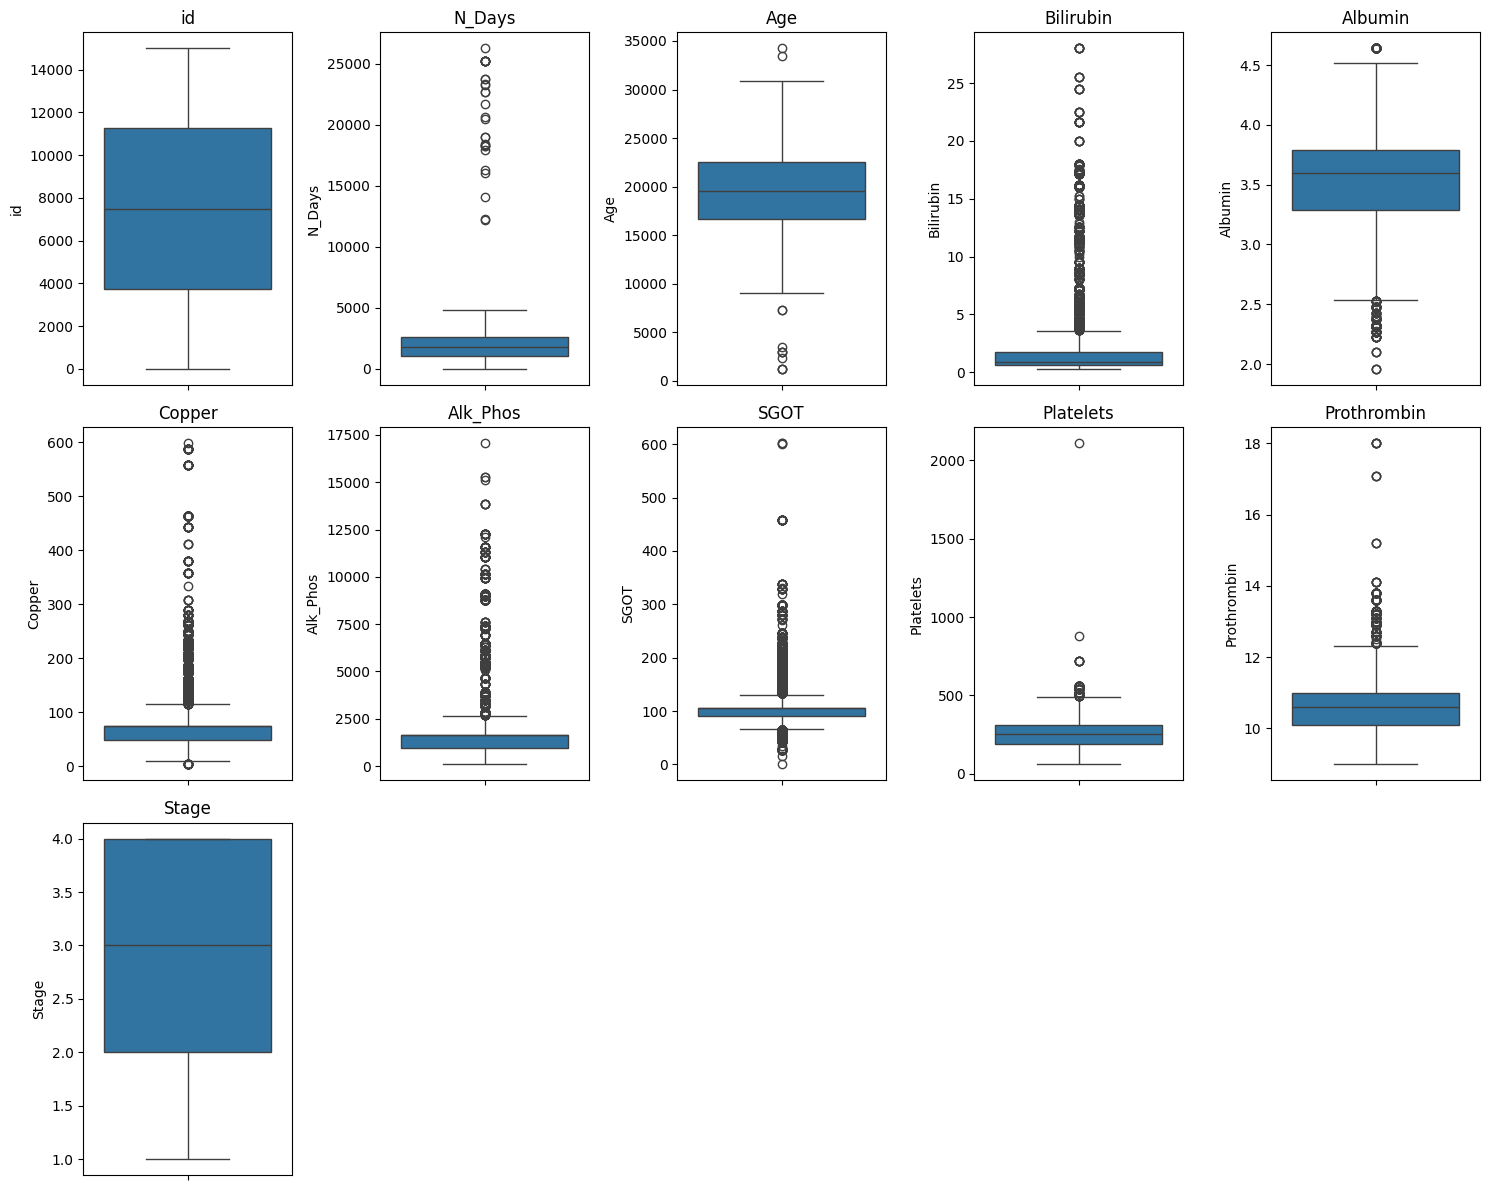

In [21]:
plt.figure(figsize=(15,12))
for i,j in enumerate(train.select_dtypes('number').columns,1):
    plt.subplot(3,5,i)
    sns.boxplot(train[j])
    plt.title(j)
plt.tight_layout()

In [22]:
temp_df = train.select_dtypes('number')

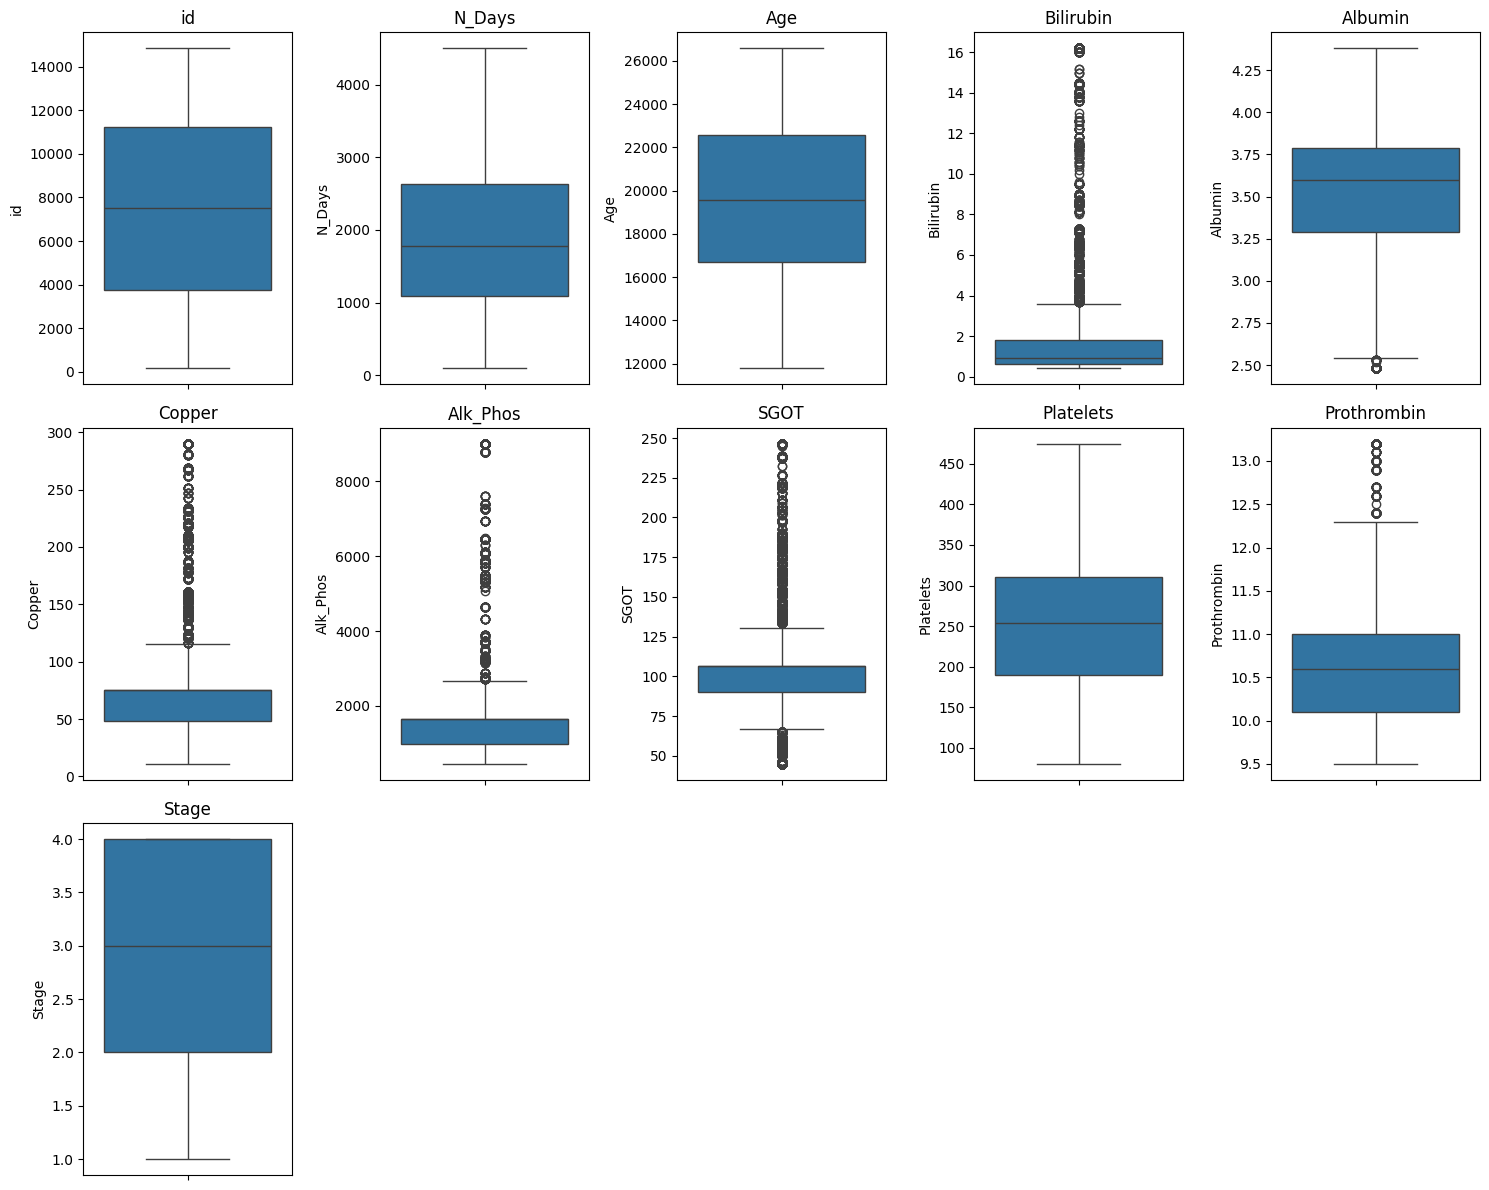

In [23]:
from scipy.stats import mstats

for col in temp_df.columns:
    temp_df[col] = mstats.winsorize(temp_df[col], limits=[0.01, 0.01]) # age,n_days,albumin,platlets is 0.01

plt.figure(figsize=(15,12))
for i,j in enumerate(temp_df.columns,1):
    plt.subplot(3,5,i)
    sns.boxplot(temp_df[j])
    plt.title(j)
plt.tight_layout()

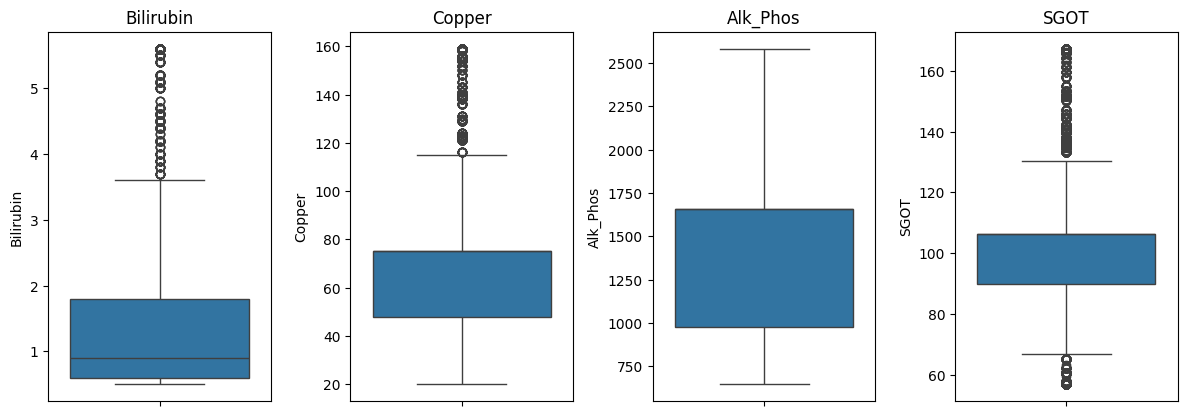

In [24]:
temp_df_new = train[['Bilirubin','Copper','Alk_Phos','SGOT']]
temp_df_new.head()
for col in temp_df_new.columns:
    temp_df_new[col] = mstats.winsorize(temp_df_new[col], limits=[0.06, 0.06]) # age,n_days,albumin,platlets is 0.01

plt.figure(figsize=(15,12))
for i,j in enumerate(temp_df_new.columns,1):
    plt.subplot(3,5,i)
    sns.boxplot(temp_df_new[j])
    plt.title(j)
plt.tight_layout()

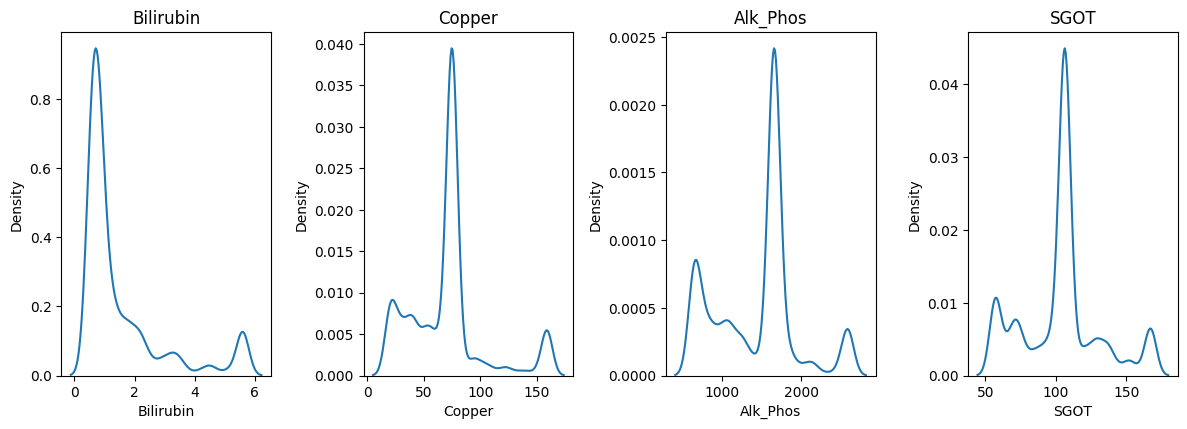

In [25]:
plt.figure(figsize=(15,12))

for i,j in enumerate(temp_df_new.columns,1):
    plt.subplot(3,5,i)
    sns.kdeplot(temp_df_new[j])
    plt.title(j)
plt.tight_layout()

# final replacing treatment

In [26]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Platelets,Prothrombin,Stage,Status
0,0.0,1086.0,Missing,18628.0,F,Missing,Missing,Missing,N,0.9,3.01,75.039084,1659.493211,106.320257,244.0,10.0,2.0,C
1,1.0,3231.0,Missing,18263.0,F,Missing,Missing,Missing,N,0.9,4.01,75.039084,1659.493211,106.320257,244.0,10.9,2.0,C
2,2.0,1072.0,Missing,14245.0,F,Missing,Missing,Missing,N,1.0,3.50,75.039084,1659.493211,106.320257,209.0,10.8,2.0,C
3,3.0,3611.0,Placebo,20604.0,F,N,Y,Y,N,0.5,3.43,54.000000,1260.000000,72.850000,430.0,10.6,2.0,D
4,4.0,2657.0,Missing,17897.0,F,Missing,Missing,Missing,N,0.9,3.93,75.039084,1659.493211,106.320257,209.0,10.0,2.0,C


In [27]:
for col in ['Age','N_Days','Albumin','Platelets']:
    train[col] = mstats.winsorize(train[col],limits=[0.01,0.01])

In [28]:
for col in ['Bilirubin','Copper','Alk_Phos','SGOT']:
    train[col] = mstats.winsorize(train[col], limits=[0.06, 0.06])

# encoding cat columns

In [29]:
cat_col.head()
for i in cat_col.columns:
    print(cat_col[i].value_counts())

Drug
Missing            6419
D-penicillamine    4574
Placebo            4007
Name: count, dtype: int64
Sex
F    14380
M      620
Name: count, dtype: int64
Ascites
N          8173
Missing    6415
Y           412
Name: count, dtype: int64
Hepatomegaly
Missing    6419
N          4671
Y          3910
Name: count, dtype: int64
Spiders
N          6818
Missing    6426
Y          1756
Name: count, dtype: int64
Edema
N    13853
S      766
Y      381
Name: count, dtype: int64
Status
C     10209
D      4446
CL      345
Name: count, dtype: int64


In [30]:
train['Sex'] = train['Sex'].replace({'F': 0, 'M': 1})
le = LabelEncoder()
train['Edema'] = le.fit_transform(train['Edema'])
train['Status'] = le.fit_transform(train['Status'])

In [31]:
pd.set_option('display.max_columns', None)

In [32]:
cat_col_ohe = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']
train_encoded = pd.get_dummies(train, columns=cat_col_ohe, drop_first=True)

In [33]:
train_encoded.head()

,id,N_Days,Age,Sex,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Platelets,Prothrombin,Stage,Status,Drug_Missing,Drug_Placebo,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y
0,0.0,1086.0,18628.0,0,0,0.9,3.01,75.039084,1659.493211,106.320257,244.0,10.0,2.0,0,True,False,False,False,False,False,False,False
1,1.0,3231.0,18263.0,0,0,0.9,4.01,75.039084,1659.493211,106.320257,244.0,10.9,2.0,0,True,False,False,False,False,False,False,False
2,2.0,1072.0,14245.0,0,0,1.0,3.50,75.039084,1659.493211,106.320257,209.0,10.8,2.0,0,True,False,False,False,False,False,False,False
3,3.0,3611.0,20604.0,0,0,0.5,3.43,54.000000,1260.000000,72.850000,430.0,10.6,2.0,2,False,True,True,False,False,True,False,True
4,4.0,2657.0,17897.0,0,0,0.9,3.93,75.039084,1659.493211,106.320257,209.0,10.0,2.0,0,True,False,False,False,False,False,False,False


# feature scaling......after train test split 

In [34]:
train_encoded.shape

(15000, 22)

In [35]:
X = train_encoded.drop(columns=['id','Status'])
y = train_encoded['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train_scaled, y_train)

y_pred_proba = model.predict_proba(X_test_scaled)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

logloss = log_loss(y_test, y_pred_proba)
print(round(logloss,2))

0.831
0.44


# applying same preprocessing steps on test file

In [37]:
test = pd.read_csv('test.csv')
print(test.shape)

(10000, 19)


In [38]:
# missing value
test = test.drop(columns=['Cholesterol', 'Tryglicerides'])

In [39]:
imputer = IterativeImputer(max_iter=10,random_state=0)
for col in test.select_dtypes('number'):
    test[[col]] = imputer.fit_transform(test[[col]])
print(test.isnull().sum())

id                 0
N_Days             0
Drug            4373
Age                0
Sex                0
Ascites         4360
Hepatomegaly    4373
Spiders         4373
Edema              0
Bilirubin          0
Albumin            0
Copper             0
Alk_Phos           0
SGOT               0
Platelets          0
Prothrombin        0
Stage              0
dtype: int64


In [40]:
for col in ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']:
    test[col].fillna('Missing',inplace=True)

In [41]:
for col in ['Age','N_Days','Albumin','Platelets']:
    test[col] = mstats.winsorize(test[col],limits=[0.01,0.01])

In [42]:
for col in ['Bilirubin','Copper','Alk_Phos','SGOT']:
    test[col] = mstats.winsorize(test[col], limits=[0.06, 0.06])

In [43]:
test['Sex'] = test['Sex'].replace({'F': 0, 'M': 1})
le = LabelEncoder()
test['Edema'] = le.fit_transform(test['Edema'])
cat_col_ohe = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']
test_encoded = pd.get_dummies(test, columns=cat_col_ohe, drop_first=True)

In [42]:
# test_encoded.drop(columns='id',inplace=True)

In [44]:
train_encoded


,id,N_Days,Age,Sex,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Platelets,Prothrombin,Stage,Status,Drug_Missing,Drug_Placebo,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y
0,0.0,1086.0,18628.0,0,0,0.9,3.01,75.039084,1659.493211,106.320257,244.0,10.0,2.0,0,True,False,False,False,False,False,False,False
1,1.0,3231.0,18263.0,0,0,0.9,4.01,75.039084,1659.493211,106.320257,244.0,10.9,2.0,0,True,False,False,False,False,False,False,False
2,2.0,1072.0,14245.0,0,0,1.0,3.50,75.039084,1659.493211,106.320257,209.0,10.8,2.0,0,True,False,False,False,False,False,False,False
3,3.0,3611.0,20604.0,0,0,0.5,3.43,54.000000,1260.000000,72.850000,430.0,10.6,2.0,2,False,True,True,False,False,True,False,True
4,4.0,2657.0,17897.0,0,0,0.9,3.93,75.039084,1659.493211,106.320257,209.0,10.0,2.0,0,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995.0,1443.0,14975.0,0,0,1.1,3.29,54.000000,1282.000000,151.900000,165.0,11.0,4.0,0,False,True,True,False,True,False,True,False
14996,14996.0,1150.0,15198.0,0,0,1.3,3.92,75.039084,1659.493211,106.320257,189.0,10.1,4.0,2,True,False,False,False,False,False,False,False
14997,14997.0,1690.0,16728.0,0,0,5.6,3.51,140.000000,1268.000000,167.400000,210.0,12.2,4.0,2,False,True,True,False,False,True,False,True
14998,14998.0,681.0,21185.0,0,0,0.8,2.93,75.039084,1659.493211,106.320257,269.0,10.4,1.0,0,True,False,False,False,False,False,False,False


In [45]:
test_encoded

,id,N_Days,Age,Sex,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Platelets,Prothrombin,Stage,Drug_Missing,Drug_Placebo,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_Missing,Spiders_N,Spiders_Y
0,15000.0,2055.0,12398.0,0,0,0.9,3.00,75.000,1622.000000,116.250000,358.0,9.9,1.0,False,False,True,False,True,False,False,True,False
1,15001.0,77.0,20442.0,0,2,2.1,3.08,161.000,2520.000000,166.400000,165.0,12.0,4.0,False,False,False,True,False,True,False,False,True
2,15002.0,3336.0,23011.0,0,0,0.7,3.35,30.000,662.000000,57.350000,344.0,10.7,2.0,False,False,True,False,True,False,False,True,False
3,15003.0,1150.0,18993.0,0,0,0.9,3.29,76.494,1640.952184,105.656142,256.0,10.8,2.0,True,False,False,False,False,False,True,False,False
4,15004.0,2363.0,18118.0,0,0,0.9,3.40,35.000,1840.000000,166.400000,356.0,10.9,2.0,False,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995.0,559.0,23011.0,0,1,0.6,3.04,76.494,1640.952184,105.656142,160.0,11.8,3.0,True,False,False,False,False,False,True,False,False
9996,24996.0,2698.0,22646.0,0,0,0.6,3.29,76.494,1640.952184,105.656142,155.0,10.4,3.0,True,False,False,False,False,False,True,False,False
9997,24997.0,1092.0,14610.0,0,0,2.8,3.46,76.494,1640.952184,105.656142,337.0,10.4,1.0,True,False,False,False,False,False,True,False,False
9998,24998.0,785.0,19358.0,0,0,5.7,3.15,76.494,1640.952184,105.656142,142.0,11.8,4.0,True,False,False,False,False,False,True,False,False


# predictions

In [46]:
X_train = train_encoded.drop(columns=['Status','id'])  
y_train = train_encoded['Status']  

X_test = test_encoded.drop(columns=['id','Spiders_Missing'])  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=2000)
model.fit(X_train_scaled, y_train)

y_test_proba = model.predict_proba(X_test_scaled)

submission_df = pd.DataFrame(y_test_proba, columns=['Status_C', 'Status_CL', 'Status_D'])
submission_df.insert(0, 'id', test_encoded['id'])  
submission_df.to_csv('submission_final.csv', index=False)



In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Ensure X and y are consistent
print(X.shape, y.shape)  # Check shapes before splitting

# Correct train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Define parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree Classifier
df = DecisionTreeClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=df, param_distributions=param_grid, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Print best parameters
print(random_search.best_params_)


(15000, 20) (15000,)
{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}
